# Multi Time series
### Train with Full Dataset

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

import statsmodels.api as sm

from evaluation import Metric, Evaluation
from plotting import Plot, ModelEvaluation
from time_series import TsHandler
from preprocess import Preprocessor, Dataset, Scaler
from multi_horizon import Prediction
from config.get_config import ConfigHandler, HOME_PATH

import warnings
warnings.filterwarnings('ignore')

import random
seed = 42

In [2]:
# Read model_params from notebooks/config/model_params.yml
model_params = ConfigHandler.read_yml("model_params_path")

WINDOWSIZE = model_params['common']['windowsize']
HORIZON = model_params['common']['horizon']
LGBM_PARAMS = model_params['lgbm']['lgbm_params']
LGBM_TRAINER_ARGS = model_params['lgbm']['lgbm_trainer_args']

print(f"windowsize:{WINDOWSIZE}")
print(f"horizon:{HORIZON}")
print(f"lgbm_params:{LGBM_PARAMS}")
print(f"lgbm_trainer_args:{LGBM_TRAINER_ARGS}")

windowsize:84
horizon:28
lgbm_params:{'objective': 'l1', 'metric': 'rmse', 'learning_rate': 0.01}
lgbm_trainer_args:{'num_boost_round': 1000, 'early_stopping_rounds': 100, 'verbose_eval': 100}


In [3]:
df_sales = pd.read_csv('./data/sales_train_evaluation.csv')
df_sales

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,1,0,3,0,1,1,0,0,1,1
30486,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
30487,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,0,0,1,2,0,1,0,1,0,2
30488,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,1,1,1,4,6,0,1,1,1,0


In [4]:
# agg to item lvl for obtaining multi time series with obvious patterns
df = df_sales.drop(columns=[
    'id',
    # 'item_id', 
    'dept_id', 
    'cat_id', 
    'store_id', 
    'state_id'
    ])
df_item_id = df.groupby(['item_id']).sum()
df_item_id

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
item_id,,,,,,,,,,,,,,,,,,,,,
FOODS_1_001,6,6,4,6,7,18,10,4,11,10,...,7,8,8,4,7,7,5,7,5,9
FOODS_1_002,4,5,7,4,3,4,1,7,2,4,...,5,8,7,2,6,5,0,6,6,4
FOODS_1_003,14,8,3,6,3,8,13,10,11,6,...,7,8,6,11,9,7,7,10,6,5
FOODS_1_004,0,0,0,0,0,0,0,0,0,0,...,115,104,107,81,73,62,71,75,83,93
FOODS_1_005,34,32,13,20,10,21,18,20,25,41,...,15,16,25,9,7,25,19,25,17,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HOUSEHOLD_2_512,5,4,1,3,2,4,2,8,7,5,...,5,7,11,4,8,3,4,5,4,7
HOUSEHOLD_2_513,0,0,0,0,0,0,0,0,0,0,...,4,0,5,3,6,3,0,9,3,4
HOUSEHOLD_2_514,4,8,2,1,1,2,3,8,2,1,...,2,2,2,6,1,0,1,4,3,3


In [5]:
df_prices = pd.read_csv('./data/sell_prices.csv')
df_prices = df_prices.groupby(['item_id', 'wm_yr_wk'])['sell_price'].mean().reset_index()
df_prices['ma'] = df_prices.groupby(['item_id'])['sell_price'].rolling(window=4).mean().reset_index(drop=True)
df_prices['sell_price_pdiff'] = (df_prices['sell_price'] - df_prices['ma']) / df_prices['ma']

df_prices

,item_id,wm_yr_wk,sell_price,ma,sell_price_pdiff
0,FOODS_1_001,11101,2.00,NaN,NaN
1,FOODS_1_001,11102,2.00,NaN,NaN
2,FOODS_1_001,11103,2.00,NaN,NaN
3,FOODS_1_001,11104,2.00,2.00000,0.000000
4,FOODS_1_001,11105,2.00,2.00000,0.000000
...,...,...,...,...,...
712585,HOUSEHOLD_2_516,11617,5.94,5.81625,0.021277
712586,HOUSEHOLD_2_516,11618,5.94,5.81625,0.021277
712587,HOUSEHOLD_2_516,11619,5.94,5.94000,0.000000
712588,HOUSEHOLD_2_516,11620,5.94,5.94000,0.000000


In [6]:
df_calendar = pd.read_csv('./data/calendar.csv', parse_dates=['date'])

df_calendar['holiday'] = df_calendar[['event_name_1', 'event_name_2']].apply(lambda x: ','.join(np.sort(x.dropna())), axis=1)
df_calendar = df_calendar[['d', 'wm_yr_wk', 'weekday', 'holiday']]
df_calendar

,d,wm_yr_wk,weekday,holiday
0,d_1,11101,Saturday,
1,d_2,11101,Sunday,
2,d_3,11101,Monday,
3,d_4,11101,Tuesday,
4,d_5,11101,Wednesday,
...,...,...,...,...
1964,d_1965,11620,Wednesday,
1965,d_1966,11620,Thursday,
1966,d_1967,11620,Friday,
1967,d_1968,11621,Saturday,


In [7]:
cat_cols = ['weekday', 'holiday']
df_calendar, label_encode_mapping = Preprocessor.label_encoding(df_calendar, cat_cols)

df_calendar

,d,wm_yr_wk,weekday,holiday,weekday_encoded,holiday_encoded
0,d_1,11101,Saturday,,6,0
1,d_2,11101,Sunday,,7,0
2,d_3,11101,Monday,,1,0
3,d_4,11101,Tuesday,,2,0
4,d_5,11101,Wednesday,,3,0
...,...,...,...,...,...,...
1964,d_1965,11620,Wednesday,,3,0
1965,d_1966,11620,Thursday,,4,0
1966,d_1967,11620,Friday,,5,0
1967,d_1968,11621,Saturday,,6,0


---------------------Step1---------------------
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.216740 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21420
[LightGBM] [Info] Number of data points in the train set: 5576621, number of used features: 84
[LightGBM] [Info] Start training from score 4.000000
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 21.7812
[200]	valid_0's rmse: 15.8803
[300]	valid_0's rmse: 12.0165
[400]	valid_0's rmse: 9.53075
[500]	valid_0's rmse: 8.09693
[600]	valid_0's rmse: 7.45802
[700]	valid_0's rmse: 7.28038
[800]	valid_0's rmse: 7.22728
[900]	valid_0's rmse: 7.19721
[1000]	valid_0's rmse: 7.19398
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 7.19398
---------------------Step2---------------------
[LightGBM] [Warning] Auto-choosing row-wise multi-

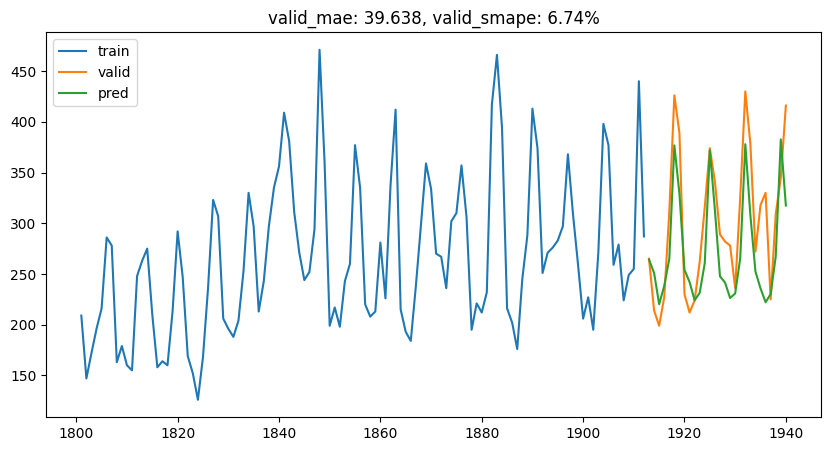


----------------------------------------------- FOODS_3_555 -----------------------------------------------


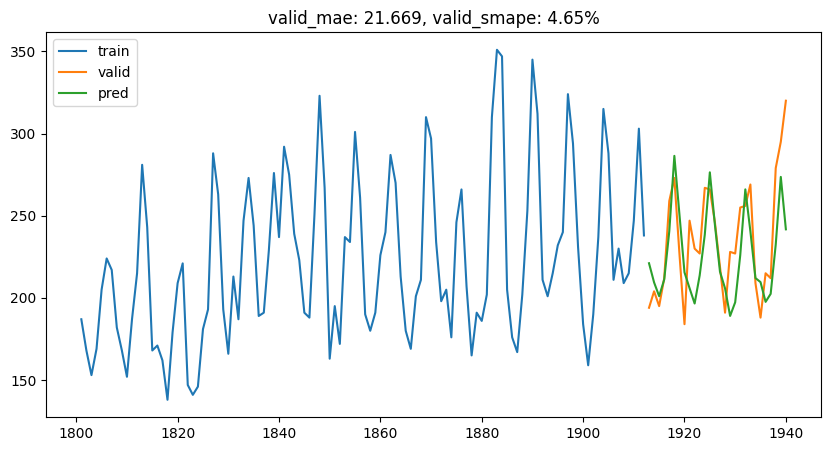


----------------------------------------------- FOODS_3_714 -----------------------------------------------


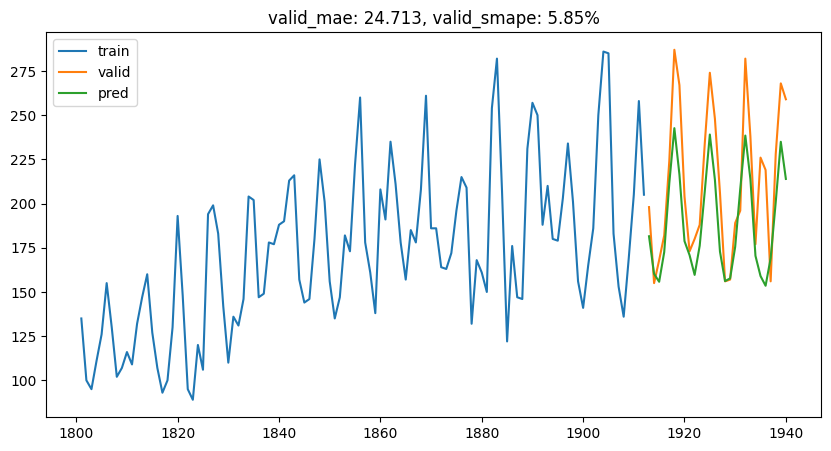


----------------------------------------------- FOODS_3_694 -----------------------------------------------


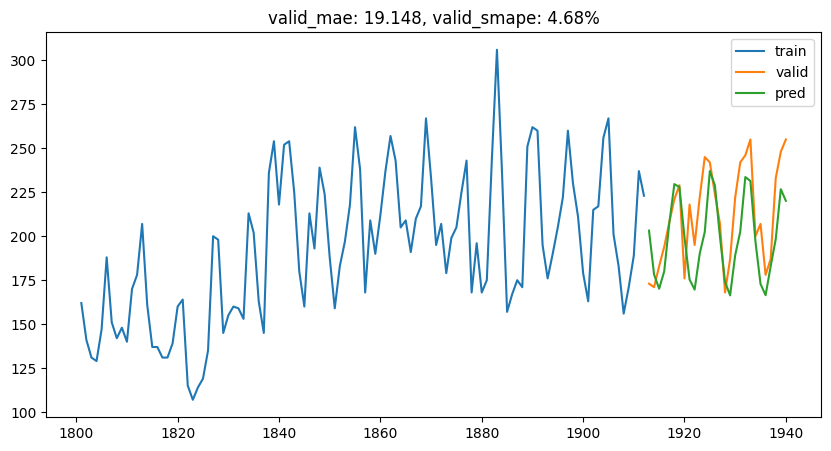


----------------------------------------------- FOODS_3_226 -----------------------------------------------


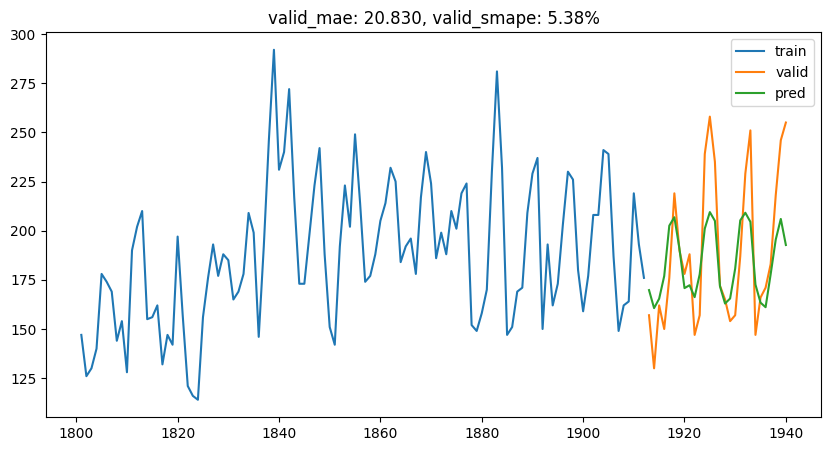


----------------------------------------------- FOODS_3_377 -----------------------------------------------


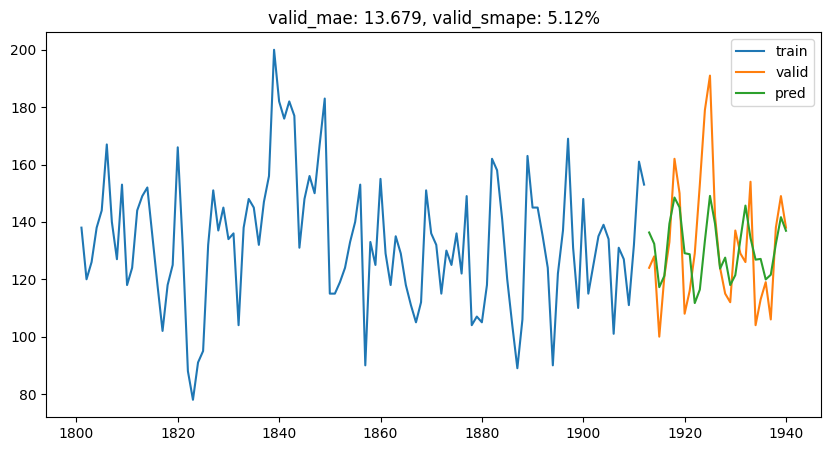


----------------------------------------------- FOODS_3_080 -----------------------------------------------


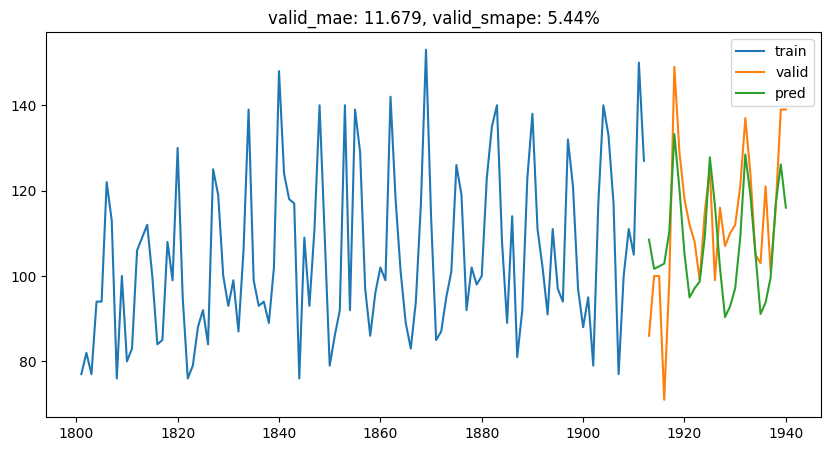


----------------------------------------------- FOODS_3_099 -----------------------------------------------


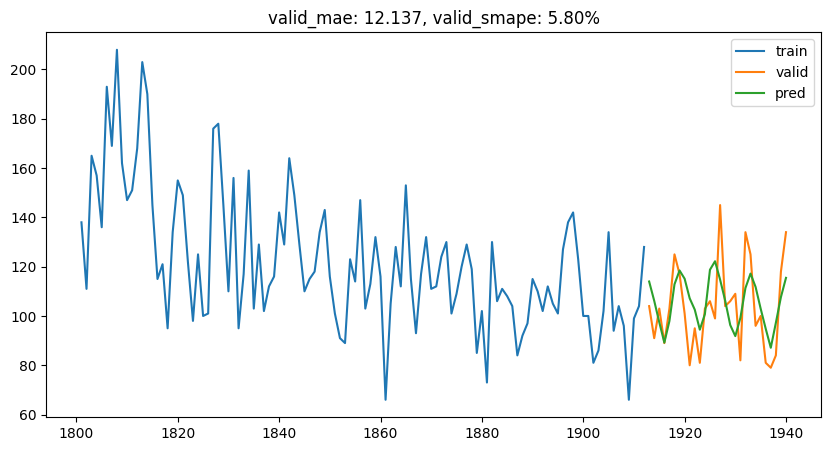


----------------------------------------------- FOODS_3_804 -----------------------------------------------


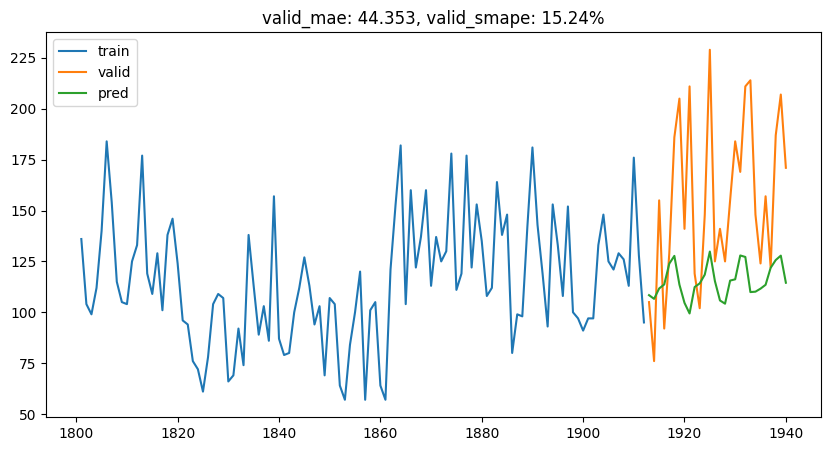

Overall mae: 4.287
Overall smape: 25.54%


In [8]:
train_names = df_item_id.index.to_list()  # len=3049
eval_names = ['FOODS_3_252', 'FOODS_3_555', 'FOODS_3_714', 'FOODS_3_694', 'FOODS_3_226', 'FOODS_3_377', 'FOODS_3_080', 'FOODS_3_099', 'FOODS_3_804']

df_y, df_y_pred, list_lgbm_model = Prediction.multi_model_train_predict_exo_features(
    df_item_id, df_calendar, df_prices,
    train_names, WINDOWSIZE, HORIZON, LGBM_PARAMS, LGBM_TRAINER_ARGS,
    exo_cat_cols=[],    #['weekday', 'holiday']
    exo_num_cols=[],    #["sell_price_pdiff"]
)

# Single item evaluation
for i, name in enumerate(eval_names):
    _, _ = Evaluation.single_item_evaluate(df_item_id, name, HORIZON, df_y_pred)

# Overall mae & smape
Evaluation.overall_evaluate(df_y, df_y_pred)

In [22]:
# save models (from step 1 to 28)
save_path = f"{HOME_PATH}/notebooks/saved/model/lgbm"

for i, model in enumerate(list_lgbm_model):
    model.save_model(f"{save_path}/step{i+1}.pkl")

In [9]:
# load model
import lightgbm as lgbm
from pathlib import Path

save_path = f"{HOME_PATH}/notebooks/saved/model/lgbm"

# for sorting the list
def extract_step_number(file_path):
    # Extract the step number from the filename using regular expressions
    match = re.search(r'step(\d+)\.pkl', str(file_path))
    if match:
        return int(match.group(1))
    return 0  # Return 0 if the step number is not found

list_loaded_model = []
list_model_paths = sorted(list(Path(save_path).glob("*.pkl")), key=extract_step_number)
for path in list_model_paths:
    list_loaded_model.append(lgbm.Booster(model_file=path))

---------------------Step1---------------------
---------------------Step2---------------------
---------------------Step3---------------------
---------------------Step4---------------------
---------------------Step5---------------------
---------------------Step6---------------------
---------------------Step7---------------------
---------------------Step8---------------------
---------------------Step9---------------------
---------------------Step10---------------------
---------------------Step11---------------------
---------------------Step12---------------------
---------------------Step13---------------------
---------------------Step14---------------------
---------------------Step15---------------------
---------------------Step16---------------------
---------------------Step17---------------------
---------------------Step18---------------------
---------------------Step19---------------------
---------------------Step20---------------------
---------------------Step21--

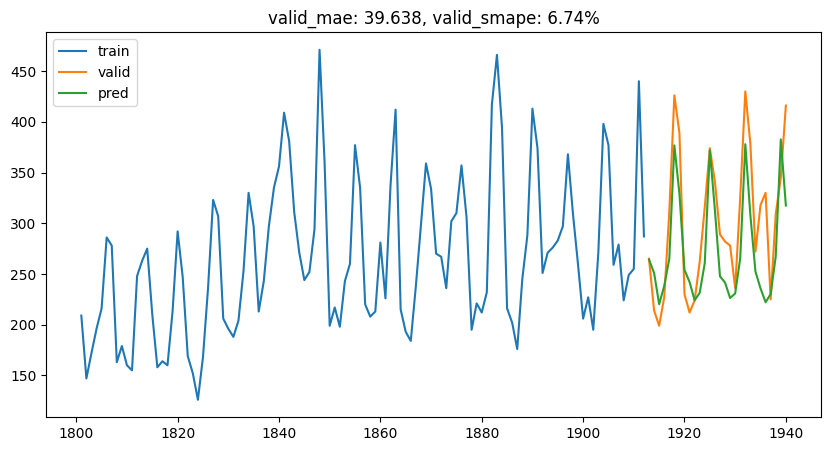


----------------------------------------------- FOODS_3_555 -----------------------------------------------


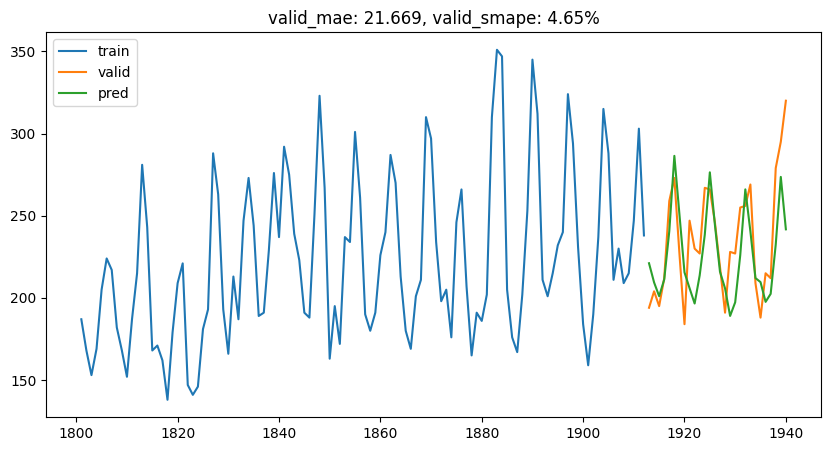


----------------------------------------------- FOODS_3_714 -----------------------------------------------


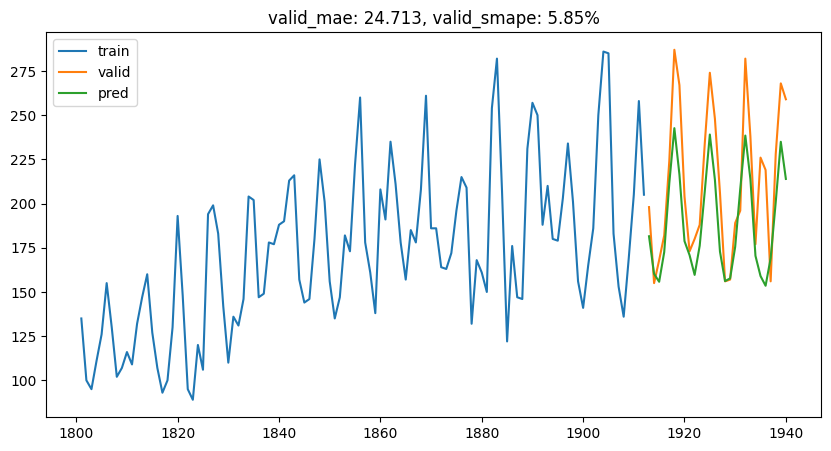


----------------------------------------------- FOODS_3_694 -----------------------------------------------


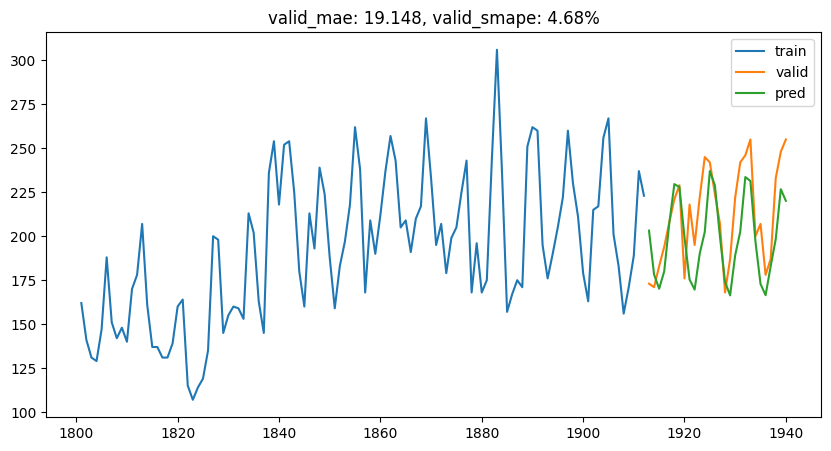


----------------------------------------------- FOODS_3_226 -----------------------------------------------


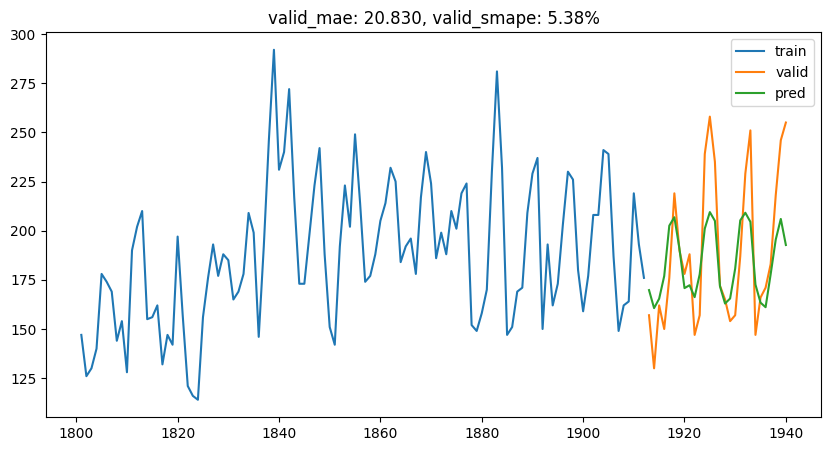


----------------------------------------------- FOODS_3_377 -----------------------------------------------


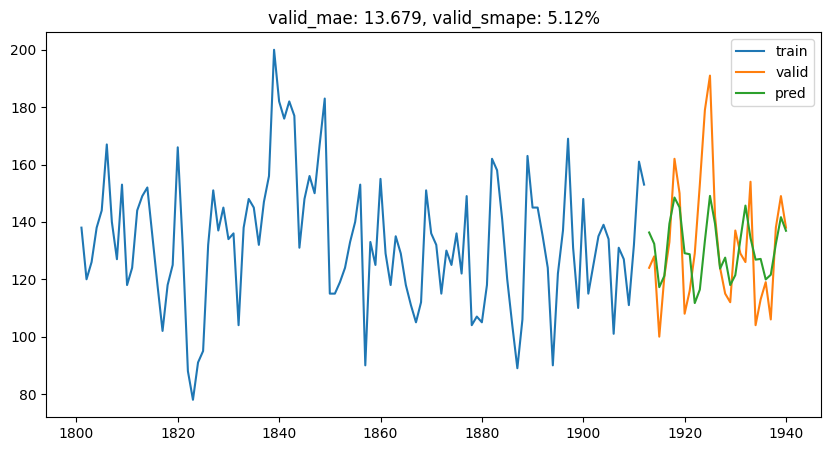


----------------------------------------------- FOODS_3_080 -----------------------------------------------


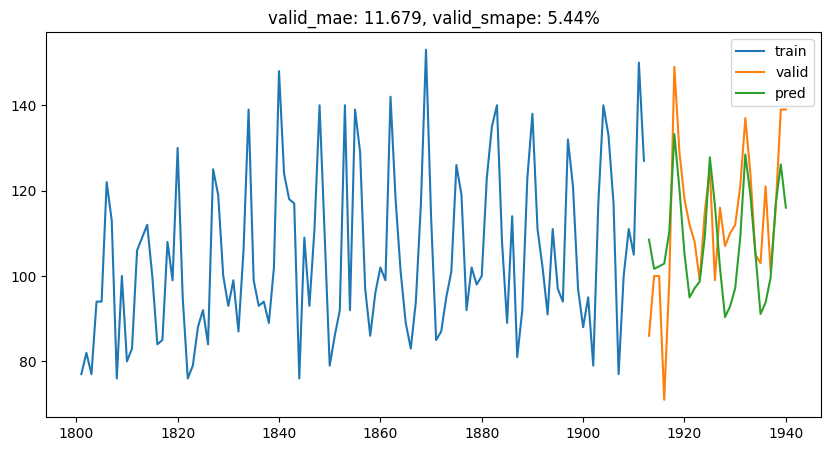


----------------------------------------------- FOODS_3_099 -----------------------------------------------


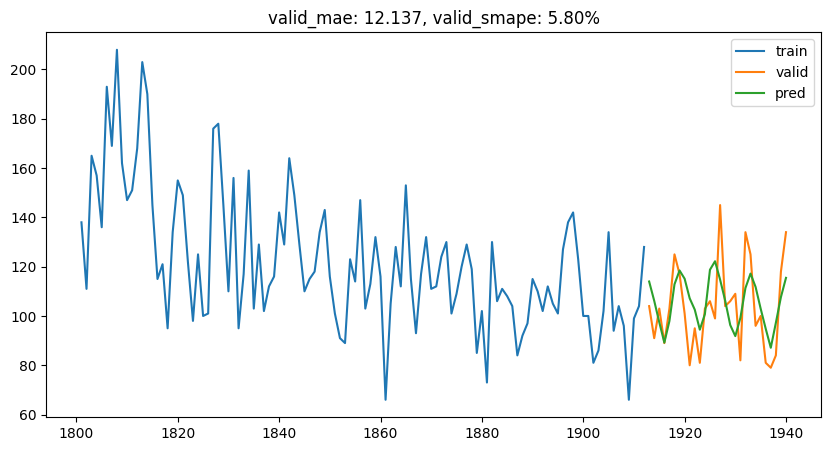


----------------------------------------------- FOODS_3_804 -----------------------------------------------


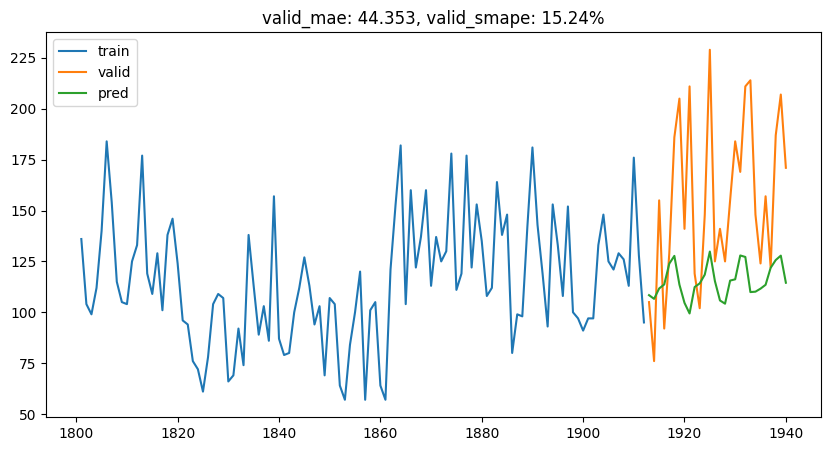

Overall mae: 23.094
Overall smape: 6.54%


In [10]:
eval_names = ['FOODS_3_252', 'FOODS_3_555', 'FOODS_3_714', 'FOODS_3_694', 'FOODS_3_226', 'FOODS_3_377', 'FOODS_3_080', 'FOODS_3_099', 'FOODS_3_804']
df_y, df_y_pred = Prediction.multi_model_predict_exo_features(df_item_id, df_calendar, df_prices, eval_names, list_loaded_model)

# Single item evaluation
for i, name in enumerate(eval_names):
    _, _ = Evaluation.single_item_evaluate(df_item_id, name, HORIZON, df_y_pred)

# Overall mae & smape
Evaluation.overall_evaluate(df_y, df_y_pred)

### Full Dataset Result
- Training time: 17.85hr
- Overall mae: 4.287
- Overall smape: 25.54%

### Eval names only Result
- Overall mae: 23.094
- Overall smape: 6.54%